<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [2]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to alter which query is being used
# uncomment one of the 5 queries, leave rest commented out
QUERY_NAME = "el_hypertension.sql"
# QUERY_NAME = "el_diabetes.sql"
# QUERY_NAME = "el_congestive_heart_failure.sql"
# QUERY_NAME = "el_kidney_failure.sql"
# QUERY_NAME = "el_artial_fibrillation.sql"


# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 10000

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 4

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2






## Section 1: Loading event log

###1.1

In [3]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=3aa4cf171109a00eb258b657904a3735b8f4f9451554d25a50129b3dff9fd3e4
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=24953 sha256=702d9a59ae81666ad24707a5fa62d62a2172d753076dc17446394a4b6b297e4f
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.4 MB/s eta 0:00:00


In [4]:
# sign in to google account linked to physionet
from google.colab import auth
auth.authenticate_user()

In [5]:
# connect to BigQuery
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [6]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [30]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,120290,Dialysis,2201-02-09 01:41:00
1,120290,Dialysis,2201-02-13 22:31:00
2,136056,Dialysis,2190-02-16 10:30:00
3,136056,Dialysis,2190-02-11 18:35:00
4,136056,Dialysis,2190-02-13 20:30:00
...,...,...,...
127266,116847,IV,2195-03-05 18:31:00
127267,155516,IV,2103-09-21 03:00:00
127268,177751,IV,2189-02-09 20:00:00
127269,121528,IV,2174-04-12 15:55:00


## Section 2: Process Discovery

In [31]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-31-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 20696
Number of events: 127271
Start events: {'Admitted': 20390, 'Entered ICU': 265, 'Discharged': 23, 'Ventilation': 18}
End events: {'Discharged': 17501, 'Left ICU': 3193, 'Admitted': 2}


In [32]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

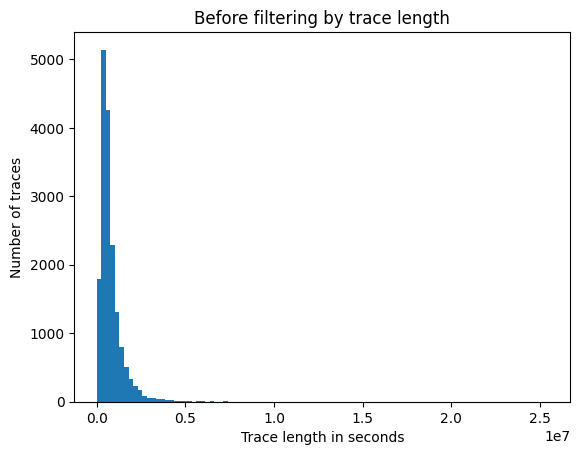

In [33]:
import matplotlib.pyplot as plt

# histogram of the trace length distribution before filtering by trace lengths
fig, ax  = plt.subplots()
trace_lengths = pm.stats.get_all_case_durations(event_log)
ax.hist(trace_lengths,bins=100)

ax.set_xlabel('Trace length in seconds')
ax.set_ylabel('Number of traces')
ax.set_title('Before filtering by trace length')

plt.show()

In [34]:
import math
# sort trace lengths from shortest to longest
sorted_lengths = sorted(trace_lengths, reverse=True)
print(max(sorted_lengths))

# remove the last 10% of the traces
pct = math.ceil(len(sorted_lengths) * 0.1)
sorted_lengths = sorted_lengths[pct:]
max_length = max(sorted_lengths)
print(max_length)

# filter by traces logner than max_length
event_log = pm.filter_case_performance(event_log, 0, max_length)

25458660.0
1493100.0


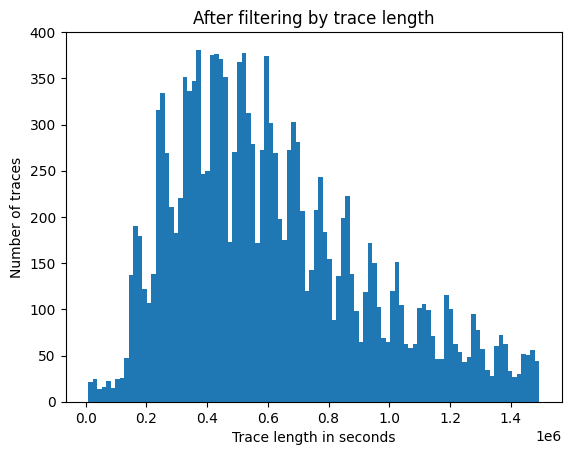

In [35]:
# histogram of the trace length distribution after filtering by trace lengths
fig, ax  = plt.subplots()
trace_lengths = pm.stats.get_all_case_durations(event_log)
ax.hist(trace_lengths,bins=100)

ax.set_xlabel('Trace length in seconds')
ax.set_ylabel('Number of traces')
ax.set_title('After filtering by trace length')

plt.show()

In [36]:
# lets recalculate the number of traces
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 15513
Number of events: 89479
Start events: {'Admitted': 15513}
End events: {'Discharged': 15513}


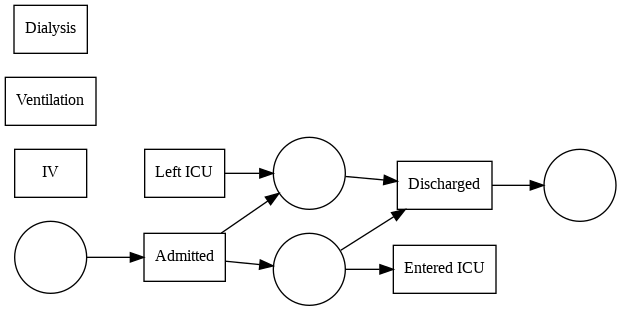

In [37]:
# create petri net using alpha miner
import graphviz
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)
pm.view_petri_net(petri_net=net)

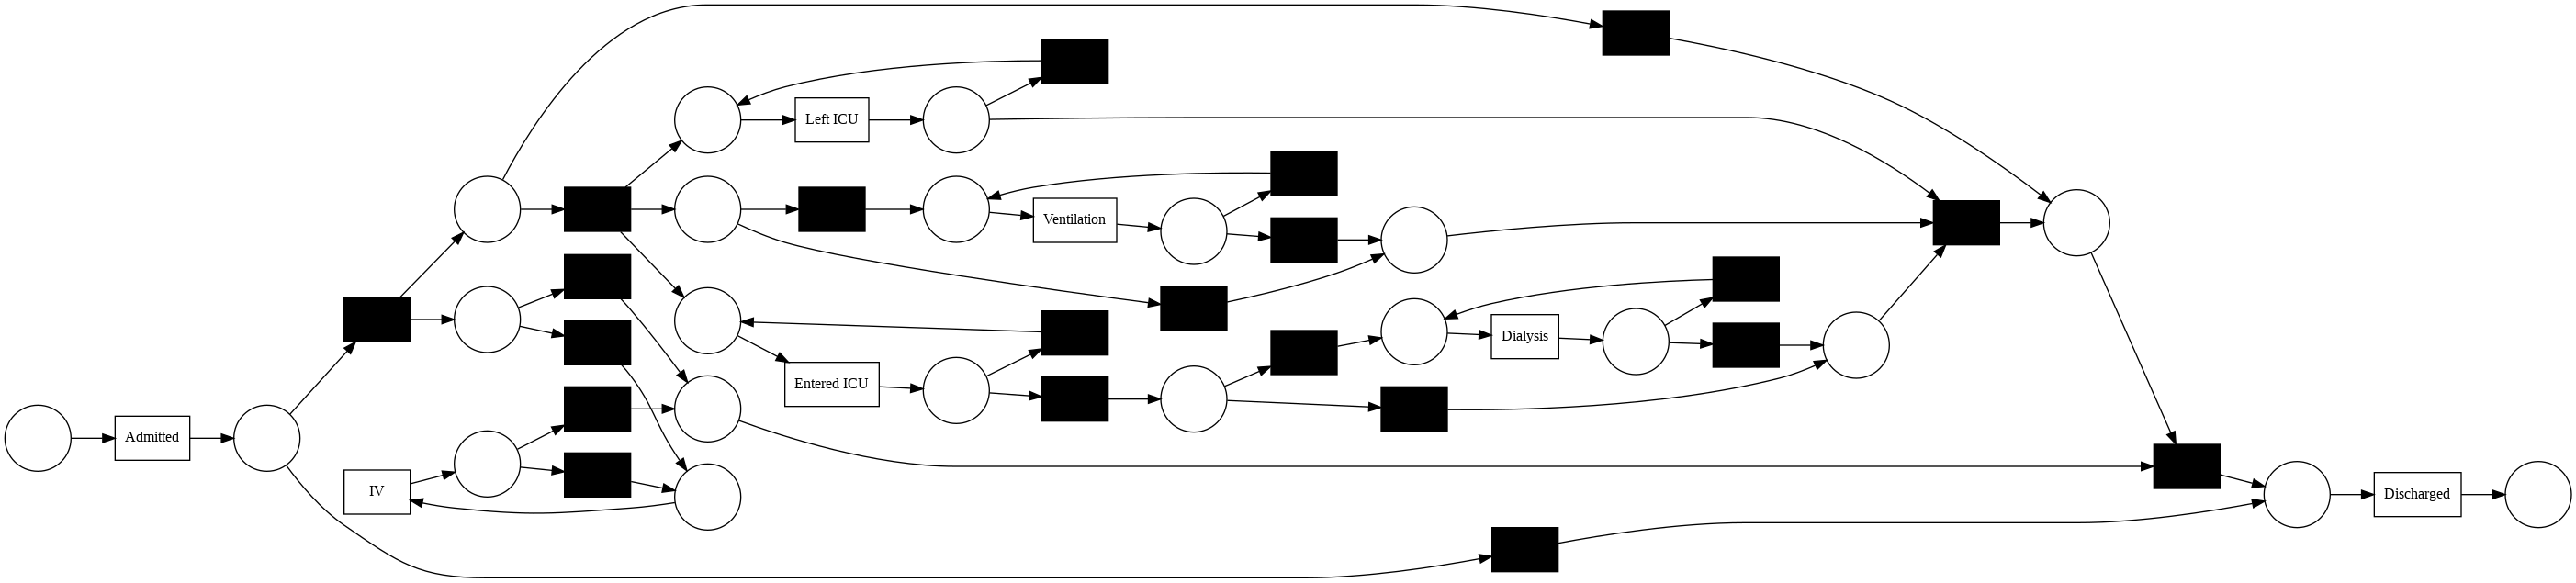

In [38]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

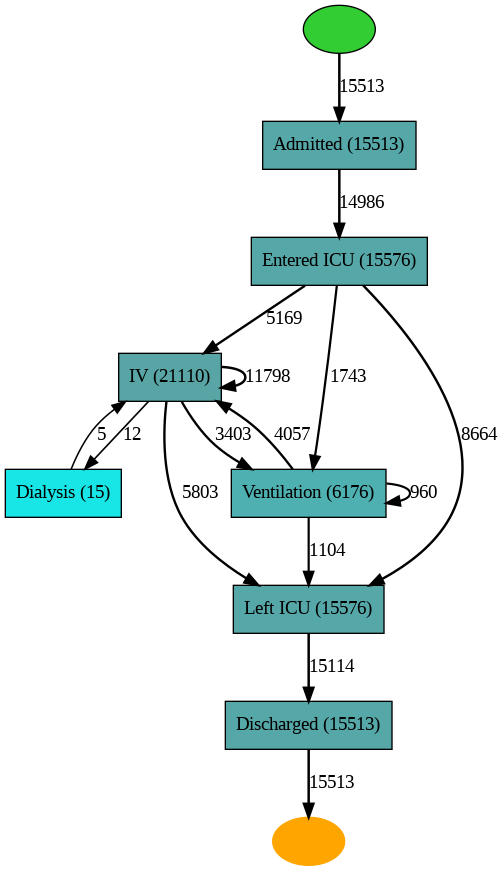

In [39]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

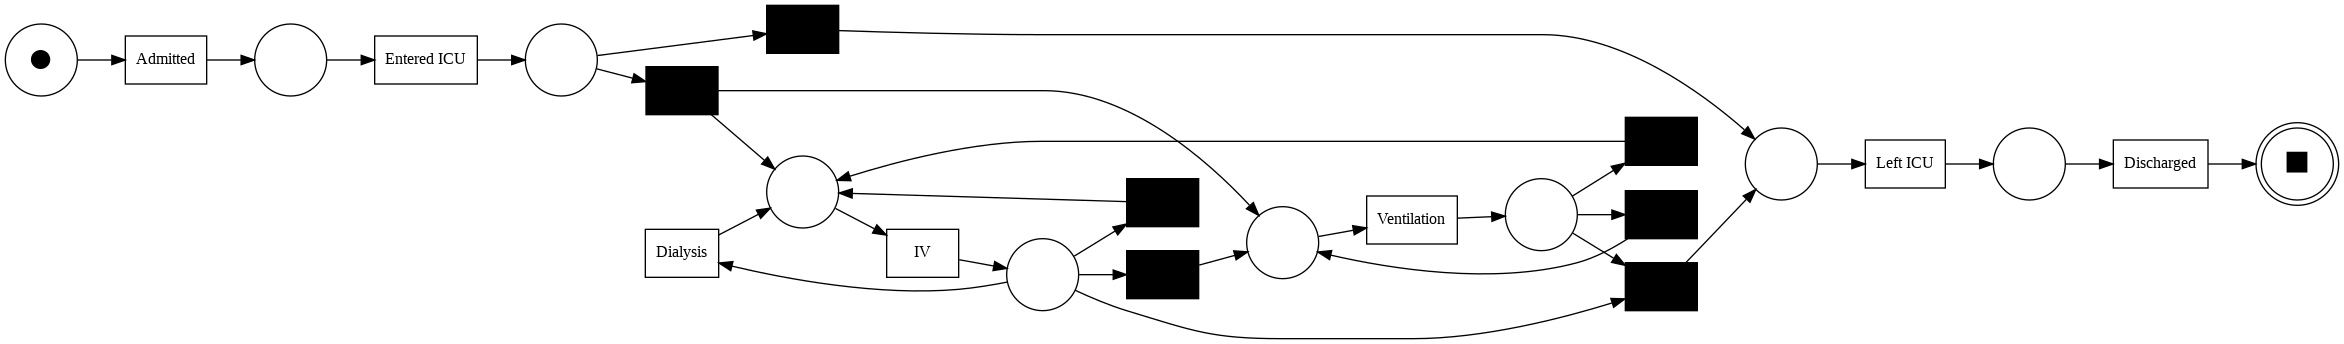

In [40]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

##Section 3: Preprocessing Data

In [41]:
from pandas.core.window.ewm import partial
import random

# function selects n cases from event log
# returns a subset of the event log
def partial_log(el, n):

  # select n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [42]:
partial_el = partial_log(event_log, NUM_TRACES)

In [43]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity

({'Admitted': '1',
  'Entered ICU': '2',
  'Ventilation': '3',
  'IV': '4',
  'Left ICU': '5',
  'Discharged': '6',
  'Dialysis': '7'},
 {'1': 'Admitted',
  '2': 'Entered ICU',
  '3': 'Ventilation',
  '4': 'IV',
  '5': 'Left ICU',
  '6': 'Discharged',
  '7': 'Dialysis'})

In [44]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

# split event log using train and test traces
train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
150,26,Admitted,2115-01-11 18:58:00
151,26,Entered ICU,2115-01-12 23:14:06
152,26,Left ICU,2115-01-16 16:44:52
153,26,Discharged,2115-01-19 13:10:00
181,33,Admitted,2200-02-24 19:13:00
...,...,...,...
89411,15500,Discharged,2152-03-10 12:30:00
89437,15505,Admitted,2101-08-23 16:43:00
89438,15505,Entered ICU,2101-08-24 15:12:52
89439,15505,Left ICU,2101-09-05 11:44:08


In [45]:
import numpy as np

# transform train data into prefix, suffix and label
def label_train(el):
  # initialise lists
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  start_times, end_times = [], []
  labeled_arr = []
  
  # create list of unique traces
  unique_traces = el['trace'].unique()
  
  for t in unique_traces:
    # sort trace chronologically
    df = el[:][el.trace == t].sort_values(by='timestamp')
    activities, timestamps = [], []

    # create sequences of activities and timestamps
    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)
      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)
    
    start_time = timestamps[0]
    end_time = timestamps[-1]
    length = len(activities)
    
    # perform min max scaling
    for i in range(length):
      timestamps[i] = (timestamps[i] - start_time).total_seconds() / max_length     

    # for each event, find prefix and suffix sequences
    for i in range(length):
      label = activities[i]
      time_label = timestamps[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]
        suffix_times = timestamps[i+1:]

      padding = []


      # pad sequences to reach desired length
      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH:
        padding.append(0.0)
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH:
        suffix_times.append(0.0)

      # store sequences in arrays
      # sequenes are truncated to math desired length
      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_times[0:PREFIX_LENGTH]))
      suffix_times_arr.append(np.array(suffix_times[0:PREFIX_LENGTH]))
      label_arr.append(label)
      label_times_arr.append(time_label)
      start_times.append(start_time)
      end_times.append(end_time)

  # return a dataframe
  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr,
                       'start times': start_times,
                       'end times': end_times
                       })
  

labeled_train_el = label_train(train_el)
labeled_train_el

,prefix,suffix,prefix times,suffix times,activity label,time label,start times,end times
0,"[0, 0, 0, 0]","[2, 3, 4, 3]","[0.0, 0.0, 0.0, 0.0]","[0.04430446721585962, 0.06365280289330923, 0.0...",1,0.000000,2162-05-16 15:56:00,2162-05-21 13:37:00
1,"[0, 0, 0, 1]","[3, 4, 3, 4]","[0.0, 0.0, 0.0, 0.0]","[0.06365280289330923, 0.06365280289330923, 0.0...",2,0.044304,2162-05-16 15:56:00,2162-05-21 13:37:00
2,"[0, 0, 1, 2]","[4, 3, 4, 4]","[0.0, 0.0, 0.0, 0.04430446721585962]","[0.06365280289330923, 0.07430178822583886, 0.1...",3,0.063653,2162-05-16 15:56:00,2162-05-21 13:37:00
3,"[0, 1, 2, 3]","[3, 4, 4, 5]","[0.0, 0.0, 0.04430446721585962, 0.063652802893...","[0.07430178822583886, 0.10440024110910187, 0.1...",4,0.063653,2162-05-16 15:56:00,2162-05-21 13:37:00
4,"[1, 2, 3, 4]","[4, 4, 5, 6]","[0.0, 0.04430446721585962, 0.06365280289330923...","[0.10440024110910187, 0.12814948764315853, 0.1...",3,0.074302,2162-05-16 15:56:00,2162-05-21 13:37:00
...,...,...,...,...,...,...,...,...
33997,"[0, 1, 2, 5]","[0, 0, 0, 0]","[0.0, 0.0, 0.084291742013261, 0.31237693389592...","[0.0, 0.0, 0.0, 0.0]",6,0.649789,2201-01-26 07:15:00,2201-02-06 12:45:00
33998,"[0, 0, 0, 0]","[2, 5, 6, 0]","[0.0, 0.0, 0.0, 0.0]","[2.344116268166901e-05, 0.05622932154577724, 0...",1,0.000000,2188-10-30 16:55:00,2188-11-02 12:40:00
33999,"[0, 0, 0, 1]","[5, 6, 0, 0]","[0.0, 0.0, 0.0, 0.0]","[0.05622932154577724, 0.16335141651597349, 0.0...",2,0.000023,2188-10-30 16:55:00,2188-11-02 12:40:00
34000,"[0, 0, 1, 2]","[6, 0, 0, 0]","[0.0, 0.0, 0.0, 2.344116268166901e-05]","[0.16335141651597349, 0.0, 0.0, 0.0]",5,0.056229,2188-10-30 16:55:00,2188-11-02 12:40:00


In [46]:
# create validation set
labeled_train_el, validation_el = train_test_split(labeled_train_el, test_size=VALIDATION_SIZE, random_state=9)

In [47]:
# function formats input so it can be fed into LSTM
def format_input(el):
  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  start_times = np.array(el['start times'])

  prefix_t = np.array(el['prefix times'])
  suffix_t = np.array(el['suffix times'])

   
  prefix_t = np.stack(prefix_t)
  prefix_t = prefix_t.reshape(prefix_t.shape[0], prefix_t.shape[1], 1)

  suffix_t = np.stack(suffix_t)
  suffix_t = suffix_t.reshape(suffix_t.shape[0], suffix_t.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_t], [suffix_t]))

  y = np.array(el['time label'])
  y = np.stack(y)

  return x, y, start_times

In [48]:
train_x, train_y, _ = format_input(labeled_train_el)
validation_x, validation_y, _ = format_input(validation_el)

In [49]:
from copy import deepcopy

# randomly remove one trace in each trace
# return event log, and test targets
def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(1,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

In [50]:
test_x, test_y = random_remove(test_el)

##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

<ipython-input-51-fa2d3316df74>:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

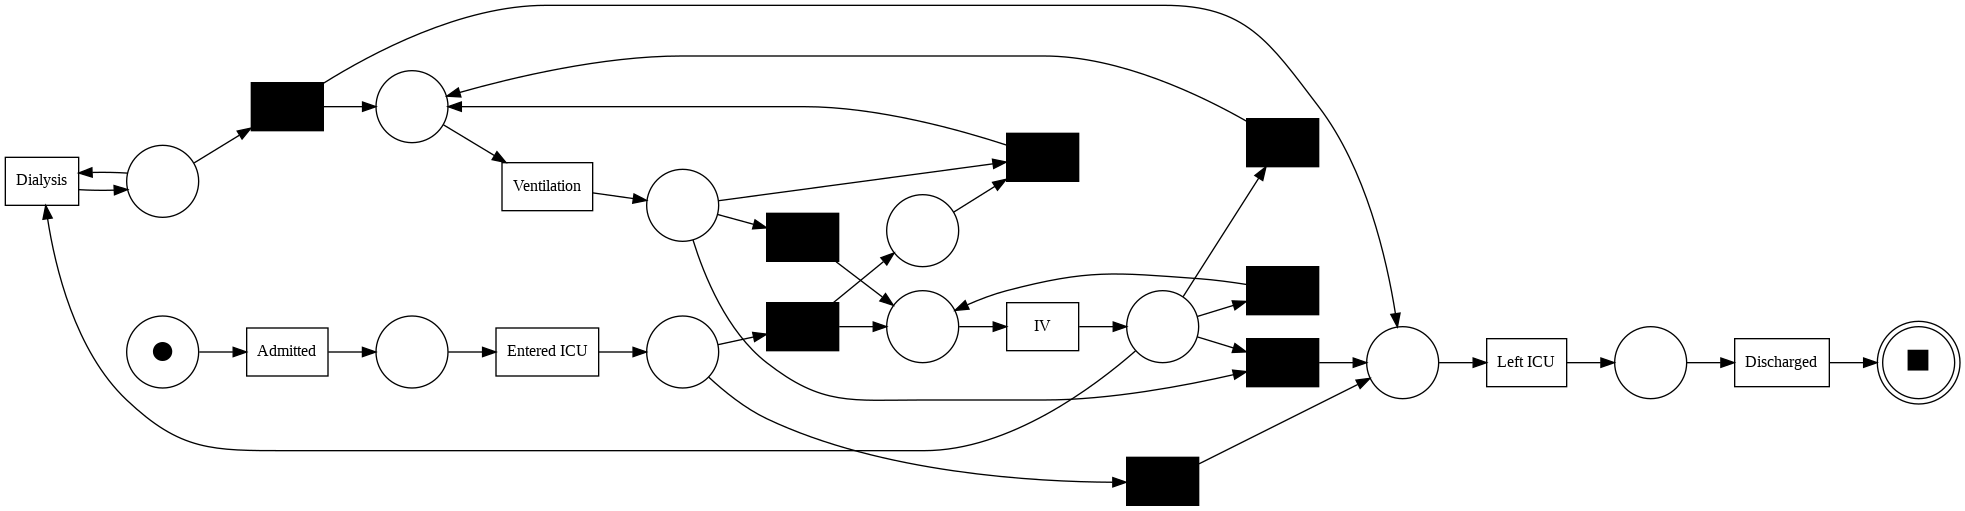

In [51]:
# format train event log as pm4py event log
train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
# petri net from heuristics miner
heuristic_net, heuristic_im, heuristic_fm = pm.discover_petri_net_heuristics(train_log)
pm.view_petri_net(heuristic_net, heuristic_im, heuristic_fm)

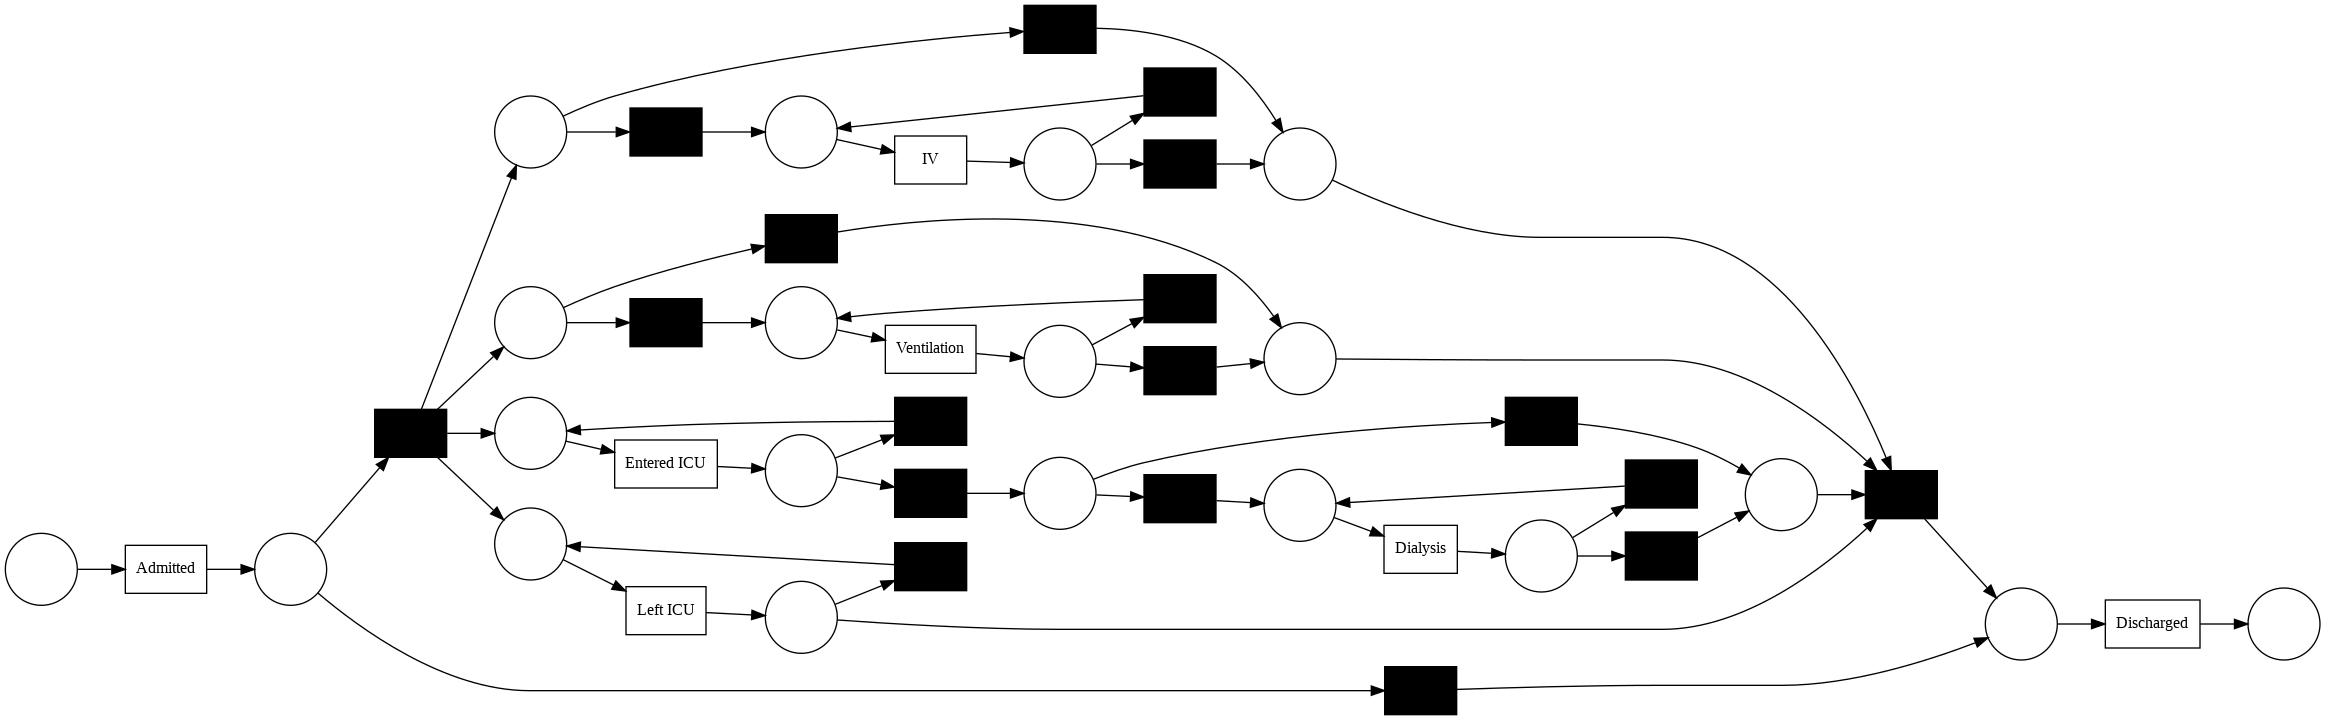

In [52]:
inductive_net, inductive_im, inductive_fm = pm.discover_petri_net_inductive(train_log)
pm.view_petri_net(petri_net=inductive_net)

<ipython-input-53-1ff381e6b524>:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. this method will be removed in a future release.
  alpha_net, alpha_im, alpha_fm = pm.discover_petri_net_alpha_plus(train_log)


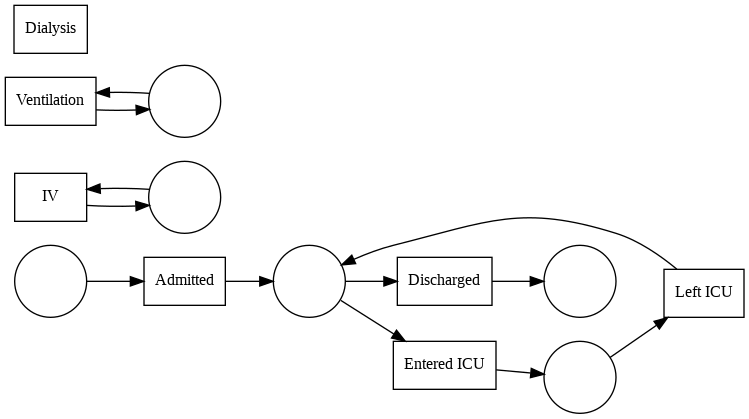

In [53]:
alpha_net, alpha_im, alpha_fm = pm.discover_petri_net_alpha_plus(train_log)
pm.view_petri_net(petri_net=alpha_net)

###4.2

In [54]:
# replay trace using alignments and token based replay
def replay_trace(el, pn, im, fm):
  replay_result_token = pm.fitness_token_based_replay(el, pn, im, fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result_alignments = pm.fitness_alignments(el, pn, im, fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  return replay_result_token['average_trace_fitness'], replay_result_alignments['average_trace_fitness']

In [55]:
# generate candidate traces by inserting event into trace
# return best fitting traces for both token based replay and alignemnts
def generate_traces(sequence, missing, trace, pn, im, fm):
    # admitted and discharged can only be at the beggining or end of the trace
    timestamps = sequence['timestamp'].tolist()
    if missing.iat[0,1] == 'Admitted':
      return pd.concat([missing,sequence], ignore_index=True), pd.concat([missing,sequence], ignore_index=True) 
    if missing.iat[0,1] == 'Discharged':
      return pd.concat([sequence,missing], ignore_index=True), pd.concat([sequence,missing], ignore_index=True)
     
    trace_length = len(timestamps) -1
    best_fitness_token = 0
    best_fitness_alignments = 0
    best_trace_token = None
    best_trace_alignments = None

    for i in range(1,trace_length+1):
      # insert event into trace
      df = pd.concat([sequence.head(i), missing, sequence.tail(trace_length-i+1)], ignore_index=True)
      inputed_df = deepcopy(df)
      previous_timestamp = inputed_df.iat[i-1,2]
      next_timestamp = inputed_df.iat[i+1,2]
      inputed_timestamp = previous_timestamp + (next_timestamp-previous_timestamp)/2 
      inputed_df.iat[i,2] = inputed_timestamp
      fitness_token, fitness_alignments = replay_trace(inputed_df, pn, im, fm)
      
      # evaluate predictions
      if fitness_token > best_fitness_token:
        best_fitness_token = fitness_token
        best_trace_token = df
      
      if fitness_alignments > best_fitness_alignments:
        best_fitness_alignments = fitness_alignments
        best_trace_alignments = df


    return best_trace_token, best_trace_alignments


In [56]:
# function repairs trace order
# returns predicted sequence orders
def predict_sequences(el, pn, im, fm):
  df_token = pd.DataFrame(columns=['trace','activity','timestamp'])
  df_alignments = pd.DataFrame(columns=['trace','activity','timestamp'])

  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]
    predicted_trace = generate_traces(sequence, missing, t, pn, im, fm)
    df_token = pd.concat([df_token,predicted_trace[0]], ignore_index=True)
    df_alignments = pd.concat([df_alignments, predicted_trace[1]], ignore_index=True)

  return df_token, df_alignments

In [59]:
# for some event logs, alpha sequences token may need to be commented out as the petri net dsicovered is not sound
alpha_sequences_token, alpha_sequences_alignments = predict_sequences(test_x, alpha_net, alpha_im, alpha_fm)
heuristic_sequences_token, heuristic_sequences_alignments = predict_sequences(test_x, heuristic_net, heuristic_im, heuristic_fm)
inductive_sequences_token, inductive_sequences_alignments = predict_sequences(test_x, inductive_net, inductive_im, inductive_fm)

###4.3 evaluate sequence prediction

In [60]:
# calculate accuracy and RMSE for predicted sequences
def evaluate_sequences(predicted, targets):
  correct, incorrect, error = 0, 0, 0
  unique_traces = targets['trace'].unique()
  
  for trace in unique_traces:
    t = targets[:][targets.trace == trace]
    target = t.index[t['timestamp'].isnull()][0]
    p = predicted[:][predicted.trace == trace]
    prediction = p.index[p['timestamp'].isnull()][0]
    
    if prediction == target:
      correct += 1
    else:
      incorrect += 1
      error += (prediction - target)**2
    

  accuracy = correct / (correct + incorrect)
  rmse = (error / len(unique_traces)) ** 0.5

  return accuracy, rmse


print(f"Heuristic token based replay: {evaluate_sequences(test_x.reset_index(), heuristic_sequences_token.reset_index())}")
print(f"Inductive token based replay: {evaluate_sequences(test_x.reset_index(), inductive_sequences_token.reset_index())}")
print(f"Alpha token based replay: {evaluate_sequences(test_x.reset_index(), alpha_sequences_token.reset_index())}")

print(f"Heuristic alignments: {evaluate_sequences(test_x.reset_index(), heuristic_sequences_alignments.reset_index())}")
print(f"Inductive alignments: {evaluate_sequences(test_x.reset_index(), inductive_sequences_alignments.reset_index())}")
print(f"Alpha alignments: {evaluate_sequences(test_x.reset_index(), alpha_sequences_alignments.reset_index())}")


Heuristic token based replay: (0.6807639836289222, 1.6922099018674284)
Inductive token based replay: (0.5361527967257844, 2.009866522415439)
Alpha token based replay: (0.7066848567530696, 1.8141854256185068)
Heuristic alignments: (0.6978171896316507, 1.8367923877182768)
Inductive alignments: (0.5361527967257844, 2.009866522415439)
Alpha alignments: (0.7066848567530696, 1.8141854256185068)


###4.4 Finish pre-processing test data

In [61]:
# label test
def label_test(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  start_times, end_times = [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    df = el[:][el.trace == t]
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)
      timestamp =  df['timestamp'][i]
      timestamps.append(timestamp)

    length = len(timestamps)
    
    start_time = pd.NaT
    end_time = pd.NaT

    if not pd.isnull(timestamps[0]):
      start_time = timestamps[0]
      for i in range(length):
        if not pd.isnull(timestamps[i]):
          timestamps[i] = (timestamps[i] - start_time).total_seconds() / max_length  
      

    order = 0
    for i in range(length):
      if pd.isnull(timestamps[i]):
        order = i
        break

    label = activities[order]
    time_label = timestamps[order]
    prefix = activities[:order]
    prefix_times = timestamps[:order]

    suffix, suffix_times = [], []

    if i != length - 1:
      suffix = activities[i+1:]
      suffix_times = timestamps[i+1:]

    padding = []

    while len(prefix) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix = padding + prefix
      
    padding = []
    
    while len(prefix_times) + len(padding) < PREFIX_LENGTH:
      padding.append(0.0)
    
    prefix_times =  padding + prefix_times

    while len(suffix) < PREFIX_LENGTH:
      suffix.append('0')

    while len(suffix_times) < PREFIX_LENGTH:
      suffix_times.append(0.0)

    prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
    suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
    prefix_times_arr.append(np.array(prefix_times[:PREFIX_LENGTH], dtype=np.double))
    suffix_times_arr.append(np.array(suffix_times[:PREFIX_LENGTH], dtype=np.double))
    label_arr.append(label)
    label_times_arr.append(time_label)
    start_times.append(start_time)
    end_times.append(end_time)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr,
                       'start times': start_times,
                       'end times': end_times})


In [62]:
labeled_test_correct = label_test(test_x)
test_x_correct, _, test_start_times = format_input(labeled_test_correct)

labeled_test = label_test(heuristic_sequences_token)
test_x, _, test_start_times = format_input(labeled_test)

labeled_test

,prefix,suffix,prefix times,suffix times,activity label,time label,start times,end times
0,"[0, 1, 2, 5]","[0, 0, 0, 0]","[0.0, 0.0, 0.06815752461322082, 0.283980979170...","[0.0, 0.0, 0.0, 0.0]",6,NaT,2115-01-11 18:58:00,NaT
1,"[0, 0, 0, 1]","[2, 3, 4, 4]","[0.0, 0.0, 0.0, 0.0]","[0.09659768267363204, 0.10496282901346192, 0.1...",3,NaT,2200-02-24 19:13:00,NaT
2,"[0, 0, 0, 1]","[5, 6, 0, 0]","[0.0, 0.0, 0.0, 0.0]","[0.10293349407273458, 0.42696403455897125, 0.0...",2,NaT,2155-07-22 02:25:00,NaT
3,"[0, 0, 0, 1]","[5, 6, 0, 0]","[0.0, 0.0, 0.0, 0.0]","[0.1498854731766124, 0.38870805706248746, 0.0,...",2,NaT,2111-03-15 21:42:00,NaT
4,"[0, 0, 0, 1]","[5, 6, 0, 0]","[0.0, 0.0, 0.0, 0.0]","[0.22614493336012323, 0.758850713281093, 0.0, ...",2,NaT,2126-02-07 13:36:00,NaT
...,...,...,...,...,...,...,...,...
1461,"[1, 2, 4, 4]","[0, 0, 0, 0]","[0.0, 4.621257785814748e-05, 0.004460518384569...","[0.0, 0.0, 0.0, 0.0]",6,NaT,2125-08-23 18:39:00,NaT
1462,"[0, 0, 1, 2]","[4, 4, 5, 6]","[0.0, 0.0, 0.0, 4.219409282700422e-05]","[0.0058669881454691585, 0.07739602169981917, 0...",4,NaT,2196-05-10 12:35:00,NaT
1463,"[0, 0, 1, 4]","[5, 6, 0, 0]","[0.0, 0.0, 0.0, 0.0030138637733574444]","[0.07001071596008304, 0.64235483222825, 0.0, 0.0]",2,NaT,2120-07-06 16:45:00,NaT
1464,"[1, 2, 3, 4]","[5, 6, 0, 0]","[0.0, 0.005611144598486371, 0.0134619248543299...","[0.07307213180630902, 0.244122965641953, 0.0, ...",4,NaT,2152-03-06 07:15:00,NaT


##Section 5: Naiive timestamp imputation method

In [63]:
# calculate mean time delta for discharge and admission
def admission_discharge_delta(el):
  discharge_delta, admission_delta = 0, 0
  unique_traces = el['trace'].unique()
  n = len(unique_traces)

  for t in unique_traces:
    df = el[:][el.trace == t]
    timestamps = []

    for i in df.index:
      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)
    
    discharge_delta += (timestamps[-1] - timestamps[-2]).total_seconds()
  mean_discharge_delta = discharge_delta/n

  return mean_discharge_delta

discharge_delta = admission_discharge_delta(train_el)

In [64]:
# naiive prediction method
def naiive(p, s):
  predictions = []
  for i in range(len(p)):
 
    if p[i][-1] != 0.0 and s[i][0] != 0:
      prediction = p[i][-1] + (s[i][0] - p[i][-1])/2
      seconds = test_start_times[i] + pd.to_timedelta(prediction * max_length, unit='s')
      predictions.append(seconds)
    elif p[i][-1] != 0.0:
      seconds = test_start_times[i] + pd.to_timedelta((p[i][-1] * max_length) + discharge_delta, unit='s')
      predictions.append(seconds)
    else:
      predictions.append(-1)

  return predictions
    
naiive_predictions = naiive(test_x[2], test_x[3])
naiive_predictions_correct = naiive(test_x_correct[2], test_x_correct[3])

## Section 6: Predicting timestamp using LSTM 

###6.1 Testing architectures

####6.1.1 Timestamps only

In [65]:
from keras.layers import LSTM, Dense, Bidirectional, average, Input, concatenate, Dropout
from keras import Model

# define input layers
prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

# define LSTM layers
lstm_layer = LSTM(32)
prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

# define dropout layers
dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

# define merge layer
merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

# define output
output = Dense(1, name='output')(merged)

# compile and train the model
td_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
td_LSTM.compile(loss='mse', optimizer='adam', metrics=['mse'])
td_LSTM.summary()
td_LSTM.fit((train_x[2], train_x[3]), train_y,  validation_data=((validation_x[2], validation_x[3]), validation_y), epochs=10)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 4, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 4, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 64)           8704        ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 64)           8704        ['suffix_input[0][0]']           
                                                                                              

####6.1.2 Combined Architecture 1

In [66]:
# define input layers
prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')
prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')

# define input merging layers
merged_prefix = concatenate([prefix_events_input, prefix_deltas_input], axis=-1)
merged_suffix = concatenate([suffix_events_input, suffix_deltas_input], axis=-1)

# define LSTM layers
lstm_layer = LSTM(32)
prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(merged_prefix)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(merged_suffix)

# define dropout layers
dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

# define merge layer
merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

# define output layer
output = Dense(1, name='output')(merged)

# compile and train model
bi_LSTM_td = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)
bi_LSTM_td.compile(loss='mse', optimizer='adam', metrics=['mse'])
bi_LSTM_td.summary()
bi_LSTM_td.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 4, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 4, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 4, 1)]      0           []                               
 r)                                                                                         

###6.2 best architecture (combined architecture 2)

In [67]:
# define input layers
prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')
prefix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_times_input')
suffix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_times_input')

# define LSTM layers
lstm_layer = LSTM(32)
prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_times_lstm = Bidirectional(lstm_layer, name='prefix_times_lstm')(prefix_times_input)
suffix_times_lstm = Bidirectional(lstm_layer, name='suffix_times_lstm')(suffix_times_input)

# define dropout layers
dropout_prefix_events = Dropout(0.2)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.2)(suffix_events_lstm)
dropout_prefix_times = Dropout(0.2)(prefix_times_lstm)
dropout_suffix_times = Dropout(0.2)(suffix_times_lstm)

# define merge layers
merged = concatenate([dropout_prefix_events, dropout_suffix_events, dropout_prefix_times, dropout_suffix_times], name='merged')

# define output layer
output = Dense(1, name='output')(merged)

# compile and train model
best_model = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_times_input, suffix_times_input],
    outputs=output)
best_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
best_model.summary()
best_model.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 4, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 4, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_times_input (InputLayer  [(None, 4, 1)]      0           []                               
 )                                                                                          

###6.3 hyperparameter tuning

In [ ]:
import keras_tuner as kt

# function builds a hypermodel for hyperparameter tuning
def build_model(hp):
  # define input layers
  prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
  suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')
  prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
  suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


  # number of LSTM units will be altered
  lstm_units = hp.Int('units', min_value=32, max_value=128, step=32)

  # define LSTM layers
  lstm_layer = LSTM(lstm_units)
  prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
  suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
  prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
  suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)

  # dropout rates will be altered
  dropout_rates = [0.0,0.1,0.2,0.3,0.4,0.5]
  dropout_rate_1 = hp.Choice('rate_1', values=dropout_rates)
  dropout_rate_2 = hp.Choice('rate_2', values=dropout_rates)
  dropout_rate_3 = hp.Choice('rate_3', values=dropout_rates)
  dropout_rate_4 = hp.Choice('rate_4', values=dropout_rates)

 # define dropout layers
  dropout_prefix_events = Dropout(dropout_rate_1)(prefix_events_lstm)
  dropout_suffix_events = Dropout(dropout_rate_2)(suffix_events_lstm)
  dropout_prefix_deltas = Dropout(dropout_rate_3)(prefix_deltas_lstm)
  dropout_suffix_deltas = Dropout(dropout_rate_4)(suffix_deltas_lstm)

  # define merge layer
  merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

  # define output layer
  output = Dense(1, name='output')(merged)

  # compile model
  model = Model(
      inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
      outputs=output)

  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  
  return model
  
build_model(kt.HyperParameters())

In [ ]:
import tensorflow as tf

# perform hyperparameter tuning using the hyperband algorithm
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_mse',
    max_epochs=10,
    seed=9
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
    validation_y),
    epochs=10,
    callbacks=[stop_early]
)

Trial 26 Complete [00h 03m 42s]
val_mse: 0.009365555830299854

Best val_mse So Far: 0.009101568721234798
Total elapsed time: 01h 06m 25s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values
# {'units': 64,
#  'rate_1': 0.0,
#  'rate_2': 0.3,
#  'rate_3': 0.0,
#  'rate_4': 0.5,
#  'tuner/epochs': 10,
#  'tuner/initial_epoch': 0,
#  'tuner/bracket': 0,
#  'tuner/round': 0}

{'units': 64,
 'rate_1': 0.0,
 'rate_2': 0.3,
 'rate_3': 0.0,
 'rate_4': 0.5,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

###6.4 Best Model

In [69]:
# define input layers
prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')
prefix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_times_input')
suffix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_times_input')

# define LSTM layers
lstm_layer = LSTM(64)
prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_times_lstm = Bidirectional(lstm_layer, name='prefix_times_lstm')(prefix_times_input)
suffix_times_lstm = Bidirectional(lstm_layer, name='suffix_times_lstm')(suffix_times_input)

# define dropout layers
dropout_prefix_events = Dropout(0.0)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.3)(suffix_events_lstm)
dropout_prefix_times = Dropout(0.0)(prefix_times_lstm)
dropout_suffix_times = Dropout(0.5)(suffix_times_lstm)

# define merge layer
merged = concatenate([dropout_prefix_events, dropout_suffix_events, dropout_prefix_times, dropout_suffix_times], name='merged')

# define output
output = Dense(1, name='output')(merged)

# compile and train model
best_model = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_times_input, suffix_times_input],
    outputs=output)
best_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
best_model.summary()
history = best_model.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=20)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 4, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 4, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_times_input (InputLayer  [(None, 4, 1)]      0           []                               
 )                                                                                          

###6.5 graphs

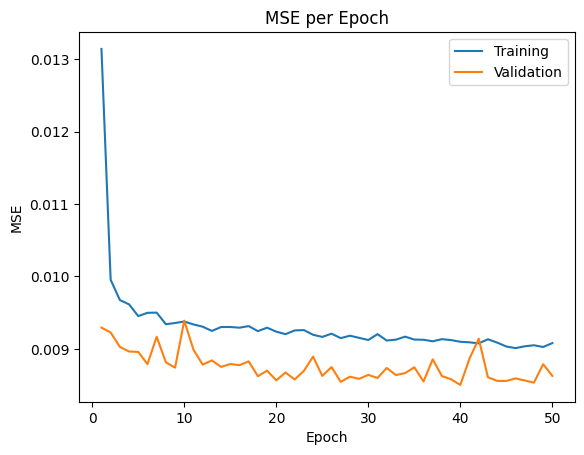

In [ ]:
import keras
from matplotlib import pyplot as plt

# plot mse per epoch
fig, ax = plt.subplots()
x = list(range(1,51))
ax.plot(x, [i for i in history.history['mse']]
)
ax.plot(x, [i for i in history.history['val_mse']]
)

# Find the maximum value and its index
ymax = np.min([i for i in history.history['val_mse']])
imax = np.argmin([i for i in history.history['val_mse']])

plt.title('MSE per Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

##Section 7: Evaluating the model

In [70]:
# function calculates RMSE
def mean_squared_error(predictions):
  seconds, minutes, hours, days = 0, 0, 0, 0
  for p, t in zip(predictions, test_y):
    if p != -1:
      seconds += (p-t).total_seconds() ** 2
  seconds = (seconds / len(predictions)) ** 0.5
  minutes = seconds / 60
  hours = minutes / 60
  days = hours / 24
  years = days / 365
  
  return seconds, minutes, hours, days, years


In [71]:
# function makes predictions
def predict(model, inputs=4):
  predictions = None
  if inputs == 4:
    predictions = model.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
  elif inputs == 2:
    predictions = model.predict([test_x[2], test_x[3]])
  predicted_times = []
  for i in range(len(predictions)):
    seconds = test_start_times[i] + pd.to_timedelta(predictions[i] * max_length, unit='s')
    predicted_times.append(seconds)
  return predicted_times


In [72]:
# evaluate timestamp only architecture
predictions_0 = predict(td_LSTM, 2)
mean_squared_error(predictions_0)

46/46 [==============================] - 2s 3ms/step


(Float64Index([186373.7571789091], dtype='float64'),
 Float64Index([3106.2292863151515], dtype='float64'),
 Float64Index([51.770488105252525], dtype='float64'),
 Float64Index([2.1571036710521887], dtype='float64'),
 Float64Index([0.00590987307137586], dtype='float64'))

In [73]:
# evaluate combined architecture 1
predictions_1 = predict(bi_LSTM_td)
mean_squared_error(predictions_1)

46/46 [==============================] - 2s 3ms/step


(Float64Index([180743.95109445316], dtype='float64'),
 Float64Index([3012.399184907553], dtype='float64'),
 Float64Index([50.206653081792545], dtype='float64'),
 Float64Index([2.091943878408023], dtype='float64'),
 Float64Index([0.0057313530915288294], dtype='float64'))

In [74]:
# evaluate best model
predictions_2 = predict(best_model)
mean_squared_error(predictions_2)

46/46 [==============================] - 5s 7ms/step


(Float64Index([183407.25600341058], dtype='float64'),
 Float64Index([3056.787600056843], dtype='float64'),
 Float64Index([50.94646000094738], dtype='float64'),
 Float64Index([2.122769166706141], dtype='float64'),
 Float64Index([0.0058158059361812075], dtype='float64'))

In [75]:
# make predictions using correct sequence orders
def predict_correct(model, inputs=4):
  predictions = None
  if inputs == 4:
    predictions = model.predict([test_x_correct[0], test_x_correct[1], test_x_correct[2], test_x_correct[3]])
  elif inputs == 2:
    predictions = model.predict([test_x_correct[2], test_x_correct[3]])
  predicted_times = []
  for i in range(len(predictions)):
    seconds = test_start_times[i] + pd.to_timedelta(predictions[i] * max_length, unit='s')
    predicted_times.append(seconds)
  return predicted_times


In [76]:
# evaluate best model using correct sequence orders
predictions_3 = predict_correct(best_model)
mean_squared_error(predictions_3)

46/46 [==============================] - 0s 7ms/step


(Float64Index([161622.98185141437], dtype='float64'),
 Float64Index([2693.7163641902393], dtype='float64'),
 Float64Index([44.89527273650399], dtype='float64'),
 Float64Index([1.8706363640209995], dtype='float64'),
 Float64Index([0.005125031134304108], dtype='float64'))

In [77]:
# evaluate naiive predictions
mean_squared_error(naiive_predictions)

(Float64Index([163846.32745703997], dtype='float64'),
 Float64Index([2730.7721242839993], dtype='float64'),
 Float64Index([45.51286873806666], dtype='float64'),
 Float64Index([1.8963695307527775], dtype='float64'),
 Float64Index([0.005195532960966514], dtype='float64'))

In [78]:
# evaluate naiive predictions using correct sequence orders
mean_squared_error(naiive_predictions_correct)

(Float64Index([154226.88001349432], dtype='float64'),
 Float64Index([2570.448000224905], dtype='float64'),
 Float64Index([42.84080000374842], dtype='float64'),
 Float64Index([1.7850333334895174], dtype='float64'),
 Float64Index([0.004890502283532924], dtype='float64'))